# Make Mercury from an Enstatite chondrite composition

In [550]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
from copy import deepcopy

## Global reference data

In [551]:
# vector of atomic masses
atmasses = {'O': 15.999,'Si': 28.084, 'Mg': 24.305, 'Al': 26.982, 'Ca': 40.078, 'Fe': 55.845,
            'Ni': 58.693, 'S': 32.06, 'Ti': 47.867, 'Mn': 54.938, 'Cr': 51.996, 'Co': 58.933,
            'Na': 22.990, 'K': 39.098}


# the mapping between the element weight percent the oxide fractions required as input for thermodynamic calculations
thermoElements = ['O', 'Si', 'Mg', 'Al', 'Ca', 'Fe', 'Ti', 'Cr', 'Na', 'K']
thermoMap = {'O': 'O', 'Si': 'SiO2', 'Mg': 'MgO', 'Al': 'Al2O3', 'Ca': 'CaO', 'Fe': 'FeO', 'Ti': 'TiO2', 'Cr': 'Cr2O3', 'Na': 'Na2O', 'K': 'K2O'}
molMasses = {'O':     atmasses['O'],
             'SiO2':  atmasses['Si'] + atmasses['O']*2,
             'MgO':   atmasses['Mg'] + atmasses['O'],
             'Al2O3': atmasses['Al'] + atmasses['O']*1.5,
             'CaO':   atmasses['Ca'] + atmasses['O'],
             'FeO':   atmasses['Fe'] + atmasses['O'],
             'TiO2':  atmasses['Ti'] + atmasses['O']*2,
             'Cr2O3': atmasses['Cr'] + atmasses['O']*1.5,
             'Na2O':  atmasses['Na'] + atmasses['O']*0.5,
             'K2O':   atmasses['K'] + atmasses['O']*0.5}

thermoMat = {'O':    [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
             'SiO2': [2, 1, 0, 0, 0, 0, 0, 0, 0, 0],
             'MgO':  [1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
             'Al2O3':[3, 0, 0, 2, 0, 0, 0, 0, 0, 0],
             'CaO':  [1, 0, 0, 0, 1, 0, 0, 0, 0, 0],
             'FeO':  [1, 0, 0, 0, 0, 1, 0, 0, 0, 0],
             'TiO2': [2, 0, 0, 0, 0, 0, 1, 0, 0, 0],
             'Cr2O3':[3, 0, 0, 0, 0, 0, 0, 2, 0, 0],
             'Na2O': [2, 0, 0, 0, 0, 0, 0, 0, 1, 0],
             'K2O':  [2, 0, 0, 0, 0, 0, 0, 0, 0, 1]}

## Readin EH composition file

In [552]:
# Read in enstatite composition (all mass percent)
dfEc = pd.read_csv('eh_comps.csv',header=0,index_col=0,na_values='nan')

# replace nan with 0
dfEc = dfEc.fillna(0)

# available elements: from intersection of atmasses keys and dfEc columns
elements = list(set(atmasses.keys()).intersection(dfEc.columns))

print('-----------------')
print('length of atmasses:', len(atmasses), 'vs. length of elements:', len(elements))

# the individual compoments (metal, silicate, sulfide etc.) need normalising to 100wt%
#  ...they are not normalised to 100% in the Javoy2010 data
dfEc[elements] = dfEc[elements].div(dfEc[elements].sum(axis=1)/100, axis=0)
dfEcTmp = deepcopy(dfEc)

print('-----------------','\nCheck sum to 100 for all elements')
dfEc[elements].sum(axis=1)

dfEc.loc['metal']['Si']

-----------------
length of atmasses: 14 vs. length of elements: 14
----------------- 
Check sum to 100 for all elements


np.float64(2.051025512756378)

## Mass balance

In [553]:
# set masses for each layer, [mass fraction, uncertainty]

masses = {'core': np.array([0.670, 0.03])}
# constrain silicate mercury by difference
masses['mantle'] = np.array([1. - masses['core'][0], 0.00])

print('-----------------','\nMasses for each layer:')
print([(k, masses[k][0]) for k in masses.keys()])

print('-----------------','\nTotal mass check:')
np.sum(np.array([masses[k][0] for k in masses.keys()]))


----------------- 
Masses for each layer:
[('core', np.float64(0.67)), ('mantle', np.float64(0.32999999999999996))]
----------------- 
Total mass check:


np.float64(1.0)

In [554]:
class Planet:
    def __init__(self, reservoirs, components, mix, mod_components=None, elements=elements):
        # reservoirs is a dictionary of reservoirs and their mass fractions
        self.reservoirs = reservoirs
        # components is a dictionary of component compositions that will be mixed to make the planet
        # compositions in weight fraction
        self.components = components
        self.components0 = deepcopy(components)
        # this is the mixing matrix, that should relate each reservoir to a mixture of components
        # if we wanted to make pseudo compoments (e.g., taking Si out of silicate and into the core)
        # then we should add a component modification matrix
        self.mix = mix

        # this is the object that we would use to modify the component compositions
        #  it is structured as a dictionary of dictionaries
        #  the outer dictionary is the component we are modifying
        #  the inner dictionaries indicate how the other components take the moles from the modified component
        #  all loss/gain is on a molar basis
        self.mod_components = mod_components
        self.mod_components0 = deepcopy(mod_components)
        
        # a list of elements to use for the mass balance calculations, defaults to the elements vector generated above in code
        self.elements = elements

    def components_reset(self):
        self.components = self.components0

    def mod_reset(self):
        self.mod_components = self.mod_components0


        # do mass balance....
    def get_compositions(self):
        # loop over planetary reservoirs
        # initialise composition of reservoir dictionary
        resComp = { r:{key: 0. for key in elements} for r in self.reservoirs.keys() }

        self.new_components = deepcopy(self.components)
        # create new components by compositional modification
        # loop over compoments
        for comp in self.mod_components.keys():
            
            for e in self.elements:
                self.new_components[comp][e] = self.components[comp][e] + self.components[comp][e]*self.mod_components[comp][comp][e]
            # renormalise to 100wt %
            self.new_components[comp] = self.new_components[comp][self.elements].div(self.new_components[comp][self.elements].sum()/100)

            # get the mass fractions of components in the bulk planet
            mfrac = {x:0. for x in self.components.keys()}
            for e_comp in set(self.mod_components[comp].keys()):
                # need to set the mass fraction of the respective components in the system for component exchange
                for e_res in self.mix.keys():
                    mfrac[e_comp] += self.mix[e_res][e_comp] * self.reservoirs[e_res][0]


            # loop over components that are not the one being modified and update their composition
            for e_comp in set(self.mod_components[comp].keys()).difference([comp]):
                # need to set the mass fraction of the respective components in the system for component exchange
                for e in self.elements:
                    self.new_components[e_comp][e] = (mfrac[e_comp] * self.components[e_comp][e] -\
                                                     mfrac[comp] * self.mod_components[comp][e_comp][e] * self.mod_components[comp][comp][e] * self.components[comp][e])/mfrac[e_comp]
                    # self.new_components[e_comp][e] = mfrac[e_comp]/(mfrac[e_comp] + mfrac[comp]) * self.components[e_comp][e] -\
                    #                                  mfrac[comp]/(mfrac[e_comp] + mfrac[comp])   * self.mod_components[comp][e_comp][e] * self.mod_components[comp][comp][e] * self.components[comp][e]


                # renormalise to 100wt %
                self.new_components[e_comp][self.elements] = self.new_components[e_comp][self.elements].div(self.new_components[e_comp][self.elements].sum()/100)

        # self.new_components = self.components.copy()

        for res in self.reservoirs:
            for comp in self.new_components:
                for e in elements:
                    resComp[res][e] = resComp[res][e] + self.mix[res][comp] * self.new_components[comp][e]

        return(resComp)

In [555]:
# mixing matrix mapping reservoirs to components
mix = {'core'  : {'metal':1, 'silicate':0, 'sulfide':0},
       'mantle': {'metal':0, 
                  'silicate': 1-1e-4, 
                  'sulfide': 1e-4}}

# mix = {'core'  : {'metal':1, 'silicate':0, 'sulfide':0},
#        'mantle': {'metal':0, 
#                   'silicate':dfEc.loc['silicate'].prop/(dfEc.loc['silicate'].prop + dfEc.loc['sulfide'].prop), 
#                   'sulfide': dfEc.loc['sulfide'].prop/(dfEc.loc['silicate'].prop + dfEc.loc['sulfide'].prop)}}


# component modification matrix
#  the inner dictionaries of arrays describe the fraction of moles lost from each component of each element
#  the inner dictionaries of arrays, for the component not being modified, should sum to 1.
#  e.g., if we modify silicate, then the metal + sulfide arrays should sum to 1 for each element
# 'Fe', 'Na', 'Co', 'Cr', 'Al', 'Ca', 'O', 'Mg', 'Si', 'K', 'Mn', 'Ti', 'Ni', 'S'
mod_components = {'metal': {'silicate': {'Fe':0., 'Na':0., 'Co':0., 'Cr':0., 'Al':0., 'Ca':0., 'O':0., 'Mg':0., 'Si':0., 'K':0., 'Mn':0., 'Ti':0., 'Ni':0., 'S':0.}, 
                            'metal':    {'Fe':0., 'Na':0., 'Co':0., 'Cr':0., 'Al':0., 'Ca':0., 'O':0., 'Mg':0., 'Si':0., 'K':0., 'Mn':0., 'Ti':0., 'Ni':0., 'S':0.},
                            'sulfide':  {'Fe':0., 'Na':0., 'Co':0., 'Cr':0., 'Al':0., 'Ca':0., 'O':0., 'Mg':0., 'Si':0., 'K':0., 'Mn':0., 'Ti':0., 'Ni':0., 'S':0.}}}
# ,
#                    'metal'   : {'silicate': np.zeros(len(atmasses)), 'metal': np.zeros(len(atmasses)), 'sulfide': np.zeros(len(atmasses))},
#                    'sulfide' : {'silicate': np.zeros(len(atmasses)), 'metal': np.zeros(len(atmasses)), 'sulfide': np.zeros(len(atmasses))}

merc = Planet(masses, 
              {'silicate': dfEc.loc['silicate'], 'metal': dfEc.loc['metal'], 'sulfide': dfEc.loc['sulfide']},
              mix,
              mod_components=mod_components)

merc.get_compositions()
# print(merc.get_compositions()['mantle']['Si'] * merc.reservoirs['mantle'][0] + merc.get_compositions()['core']['Si'] * merc.reservoirs['core'][0])

{'core': {'Fe': np.float64(90.54527263631816),
  'Na': np.float64(0.0),
  'Co': np.float64(0.31015507753876936),
  'Cr': np.float64(0.0),
  'Al': np.float64(0.0),
  'Ca': np.float64(0.0),
  'O': np.float64(0.0),
  'Mg': np.float64(0.0),
  'Si': np.float64(2.051025512756378),
  'K': np.float64(0.0),
  'Mn': np.float64(0.0),
  'Ti': np.float64(0.0),
  'Ni': np.float64(7.093546773386692),
  'S': np.float64(0.0)},
 'mantle': {'Fe': np.float64(0.33375975410839237),
  'Na': np.float64(1.0356715404882604),
  'Co': np.float64(0.0),
  'Cr': np.float64(0.12961013632583127),
  'Al': np.float64(1.3543350015528286),
  'Ca': np.float64(1.0161705487178967),
  'O': np.float64(47.002569465192714),
  'Mg': np.float64(19.41867218525985),
  'Si': np.float64(29.575769345682694),
  'K': np.float64(0.08964031537389677),
  'Mn': np.float64(0.030082683393508874),
  'Ti': np.float64(0.010027232270343524),
  'Ni': np.float64(1.973164956590371e-06),
  'S': np.float64(0.003689818468823994)}}

/var/folders/4n/4ck331k92b33y7_w0vxrgmtc0000gn/T/ipykernel_31071/1804165405.py:67: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dfEcTmp['Si'].loc['metal'] = si
/var/folders/4n/4ck331k92b33y7_w0vxrgmtc0000gn/T/ipykernel_31071/1804165405.py:6

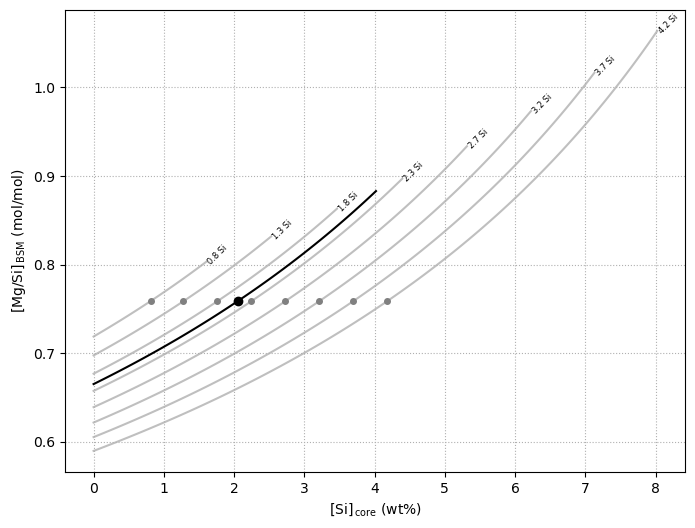

In [556]:
fg, ax = plt.subplots()

mod_components = {'metal': {'silicate': {'Fe':0., 'Na':0., 'Co':0., 'Cr':0., 'Al':0., 'Ca':0., 'O':0., 'Mg':0., 'Si':0., 'K':0., 'Mn':0., 'Ti':0., 'Ni':0., 'S':0.}, 
                            'metal':    {'Fe':0., 'Na':0., 'Co':0., 'Cr':0., 'Al':0., 'Ca':0., 'O':0., 'Mg':0., 'Si':0., 'K':0., 'Mn':0., 'Ti':0., 'Ni':0., 'S':0.},
                            'sulfide':  {'Fe':0., 'Na':0., 'Co':0., 'Cr':0., 'Al':0., 'Ca':0., 'O':0., 'Mg':0., 'Si':0., 'K':0., 'Mn':0., 'Ti':0., 'Ni':0., 'S':0.}}}

merc = Planet(masses,
              {'silicate': dfEc.loc['silicate'], 'metal': dfEc.loc['metal'], 'sulfide': dfEc.loc['sulfide']},
              mix,
              mod_components=mod_components)

ax.plot(merc.get_compositions()['core']['Si'], merc.get_compositions()['mantle']['Mg']/merc.get_compositions()['mantle']['Si'] * (atmasses['Si']/atmasses['Mg']), 'o',
        color='black', zorder=2)

# factors of Si remova/addition to loop over
facs = np.linspace(-1,1,100)
# output for plotting
out = np.zeros((len(facs), 3))
# matrix for output for thermodynamic calculations
thermoOut = np.zeros((len(facs), 1+len(thermoElements)))
for i, xi in enumerate(facs):
        mod_components['metal']['metal']['Si'] = xi
        mod_components['metal']['silicate']['Si'] = 1

        merc.mod_components = mod_components

        comp = merc.get_compositions()

        # store for plotting
        out[i, 0] = xi
        out[i, 1] = comp['core']['Si']
        out[i, 2] = comp['mantle']['Mg']/comp['mantle']['Si'] * (atmasses['Si']/atmasses['Mg'])

        # store for thermodynamic calculations
        thermoOut[i, 0] = comp['core']['Si']

        tmpComp = np.array([comp['mantle'][e] for e in thermoElements])
        #  handle oxygen separately
        tmpComp[0] = 1e-3
        thermoOut[i, 1] = tmpComp[0]

        thermoOut[i, 2:] = [comp['mantle'][e] * molMasses[thermoMap[e]]/atmasses[e] for e in thermoElements[1:]]
        # renormalise to 100%
        thermoOut[i, 1:] = thermoOut[i, 1:] / np.sum(thermoOut[i, 1:]) * 100





ax.plot(out[:,1], out[:,2], color='black', zorder=2)

# reset planet state for loop over silica content
mod_components = {'metal': {'silicate': {'Fe':0., 'Na':0., 'Co':0., 'Cr':0., 'Al':0., 'Ca':0., 'O':0., 'Mg':0., 'Si':0., 'K':0., 'Mn':0., 'Ti':0., 'Ni':0., 'S':0.}, 
                            'metal':    {'Fe':0., 'Na':0., 'Co':0., 'Cr':0., 'Al':0., 'Ca':0., 'O':0., 'Mg':0., 'Si':0., 'K':0., 'Mn':0., 'Ti':0., 'Ni':0., 'S':0.},
                            'sulfide':  {'Fe':0., 'Na':0., 'Co':0., 'Cr':0., 'Al':0., 'Ca':0., 'O':0., 'Mg':0., 'Si':0., 'K':0., 'Mn':0., 'Ti':0., 'Ni':0., 'S':0.}}}

merc = Planet(masses,
              {'silicate': dfEc.loc['silicate'], 'metal': dfEc.loc['metal'], 'sulfide': dfEc.loc['sulfide']},
              mix,
              mod_components=mod_components)

# manually set range of Si in core
sis = np.linspace(0.8,4.2,8)
for si in sis:
        merc.mod_reset()

        dfEcTmp['Si'].loc['metal'] = si
        dfEcTmp[elements] = dfEcTmp[elements].div(dfEcTmp[elements].sum(axis=1)/100, axis=0)

        # reset planet comp at each new silica composition
        mod_components = {'metal': {'silicate': {
                'Fe':0., 'Na':0., 'Co':0., 'Cr':0., 'Al':0., 'Ca':0., 'O':0., 'Mg':0., 'Si':0., 'K':0., 'Mn':0., 'Ti':0., 'Ni':0., 'S':0.}, 
                            'metal':    {'Fe':0., 'Na':0., 'Co':0., 'Cr':0., 'Al':0., 'Ca':0., 'O':0., 'Mg':0., 'Si':0., 'K':0., 'Mn':0., 'Ti':0., 'Ni':0., 'S':0.},
                            'sulfide':  {'Fe':0., 'Na':0., 'Co':0., 'Cr':0., 'Al':0., 'Ca':0., 'O':0., 'Mg':0., 'Si':0., 'K':0., 'Mn':0., 'Ti':0., 'Ni':0., 'S':0.}}}


        merc = Planet(masses, 
              {'silicate': dfEcTmp.loc['silicate'], 'metal': dfEcTmp.loc['metal'], 'sulfide': dfEcTmp.loc['sulfide']},
              mix,
              mod_components=mod_components)
    

        # ax.plot(merc.get_compositions()['core']['Si'], merc.get_compositions()['mantle']['Mg']/merc.get_compositions()['mantle']['Si'] * (atmasses['Si']/atmasses['Mg']), 'o',
                # color='black')

        ax.plot(merc.get_compositions()['core']['Si'], merc.get_compositions()['mantle']['Mg']/merc.get_compositions()['mantle']['Si'] * (atmasses['Si']/atmasses['Mg']), 'o',
        color='grey', zorder=1, markersize=4)

        out = np.zeros((len(facs), 3))
        for i, xi in enumerate(facs):
                mod_components['metal']['metal']['Si'] = xi
                mod_components['metal']['silicate']['Si'] = 1

                merc.mod_components = mod_components

                comp = merc.get_compositions()

                out[i, 0] = xi
                out[i, 1] = comp['core']['Si']
                out[i, 2] = comp['mantle']['Mg']/comp['mantle']['Si'] * (atmasses['Si']/atmasses['Mg'])
                # print(comp['mantle']['Si'] * merc.reservoirs['mantle'][0] + comp['core']['Si'] * merc.reservoirs['core'][0])
                # print(comp['core']['Si'])
                # print(comp['core'])
                # print(comp['mantle'])
                # break
        ax.plot(out[:,1], out[:,2], color='grey', alpha=0.5, zorder=1)

        ax.annotate('{:.1f} Si'.format(si), (out[-1, 1], out[-1, 2]), xytext=(0,5), 
                    rotation=45, fontsize=6, horizontalalignment='left', verticalalignment='center', textcoords='offset points')


# ax.set_xlim([0, 4])

ax.set_ylabel(r'$\mathsf{[Mg/Si]}_\mathsf{\,BSM}$ (mol/mol)')
ax.set_xlabel(r'$\mathsf{[Si]}_\mathsf{\,core}$ (wt%)')

ax.grid(ls=':')

fg.set_figwidth(8)
fg.set_figheight(6)

In [557]:
print([thermoMap[e] for e in thermoElements])
thermoOut[50,2:]
thermoOut[50,5]/thermoOut[50,2] * molMasses['SiO2']/molMasses['CaO']

['O', 'SiO2', 'MgO', 'Al2O3', 'CaO', 'FeO', 'TiO2', 'Cr2O3', 'Na2O', 'K2O']


np.float64(0.024110237654956856)

In [ ]:
thermoOut[50,2:]
['{e} {d:.1f}'.format(e, thermoOut[50,i+1]) for i, e in enumerate(thermoMap.keys())

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (119283559.py, line 2)

In [89]:
dfEc[elements].sum(axis=1)/100

Phase
silicate    1.0036
sulfide     1.0136
metal       0.9995
dtype: float64

In [196]:
1. + None

TypeError: unsupported operand type(s) for +: 'float' and 'NoneType'